# Tarea 2
## Estimación de movimiento global

ñDadas dos imágenes de entrada:  

![Mi imagen](image.png)

1. Estimar el vector de desplazamiento $\vec{d} = (d_x, d_y)$, resolviendo el siguiente problema de optimización:

   $$
   \min_{\vec{d}} \, \mathcal{E}(\vec{d}) = \sum_{\vec{x} \in \Omega} \left[ I_k(\vec{x}) - I_{k-1}(\vec{x} + \vec{d}) \right]^2
   $$

   a) Usando el algoritmo de Lucas-Kanade (Alineamiento Aditivo).  

   b) Usando el algoritmo de Baker-Matthews (Alineamiento por Composición Inversa).
   


2. Aplicar el desplazamiento encontrado a la imagen $I_{k-1}$:
$$
\tilde{I}_{k-1} = I_{k-1} (\vec{x} + \vec{d})
$$
y mostrar la imagen $\tilde{I}_{k-1}$.


3. Calcular $I_r = \left| I_k - \tilde{I}_{k-1} \right|$ y mostrar la imagen $I_r$.







## a. Algoritmo de Lucas-Kanade (Alineamiento Aditivo)
Tenemos el siguiente pseudocódigo.
1. Transf. la imagen $I(W(\vec{x}; \vec{p}))$
2. Calcular el error $E(\vec{x}) = [T(\vec{x} )- I(W(\vec{x}; \vec{p}))]$.
3. Calcular el gradiente $\nabla I(\vec{x}'), x' = W(\vec{x}; \vec{p})$.
4. Evaluar el Jacobiano $\frac{\partial W}{\partial \vec{p}}$.
5. Calcular el Hessiano $ H = \sum_{\vec{x}} [\nabla I \frac{\partial W}{\partial \vec{p}}]^T[\nabla I \frac{\partial W}{\partial \vec{p}}] $.
6. Calcular la solución aprox. $ \vec{\Delta p} = H^{-1} [\nabla I \frac{\partial W}{\partial \vec{p}}]^T E(\vec{x})$.
7. Actualizar los parámetros $\vec{p} = \vec{p} + \vec{\Delta p}$.

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2

A continuación se presentan algunas funciones a utilizar: 
En la función <pre> warp_afin(img, p)</pre> se da el warped con un ones_like porque estamos utilizando un fondo negro para nuestros algoritmos de lukas-kanade y baker-matthews.


In [2]:
def warp_afin(img, p):
    h, w = img.shape
    warped = np.ones_like(img)
    for y in range(h):
        for x in range(w):
            x_prima = x + p[0]
            y_prima = y + p[1]
            # Aplicamos la transformación afín
            if 0 <= x_prima < w and 0 <= y_prima < h:
                warped[y, x] = img[int(y_prima), int(x_prima)]
    return warped
def Jacobian(x, y):
    return np.eye(2, dtype= np.float32) #matriz identidad 2x2

p = np.zeros(2)

## Aquí vamos a inicializar las imágenes y figuras a usar

### Cuadrado

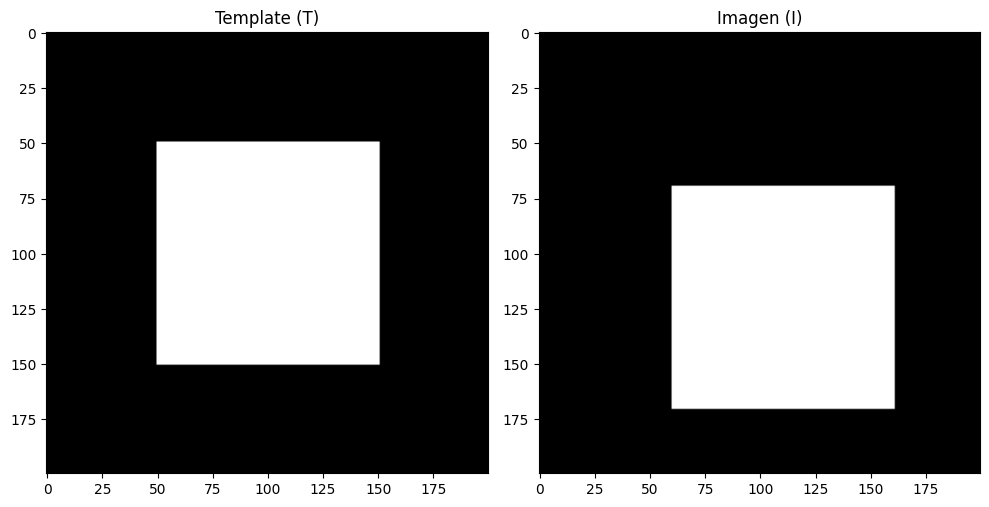

In [33]:
# Crear imágenes de prueba (rectángulo desplazado)
T_rectangulo = np.zeros((200, 200), dtype=np.uint8)
cv2.rectangle(T_rectangulo, (50, 50), (150,150), 255, -1)
    
I_rectangulo = np.zeros((200, 200), dtype=np.uint8)
cv2.rectangle(I_rectangulo, (60, 70), (160,170), 255, -1)  #con desplazamiento (10, 20)

plt.figure(figsize=(10, 5))
    
plt.subplot(1, 2, 1)
plt.imshow(T_rectangulo, cmap='gray')
plt.title('Template (T)')
    
plt.subplot(1, 2, 2)
plt.imshow(I_rectangulo, cmap='gray')
plt.title('Imagen (I)')

plt.tight_layout()
plt.show()

### Círculo

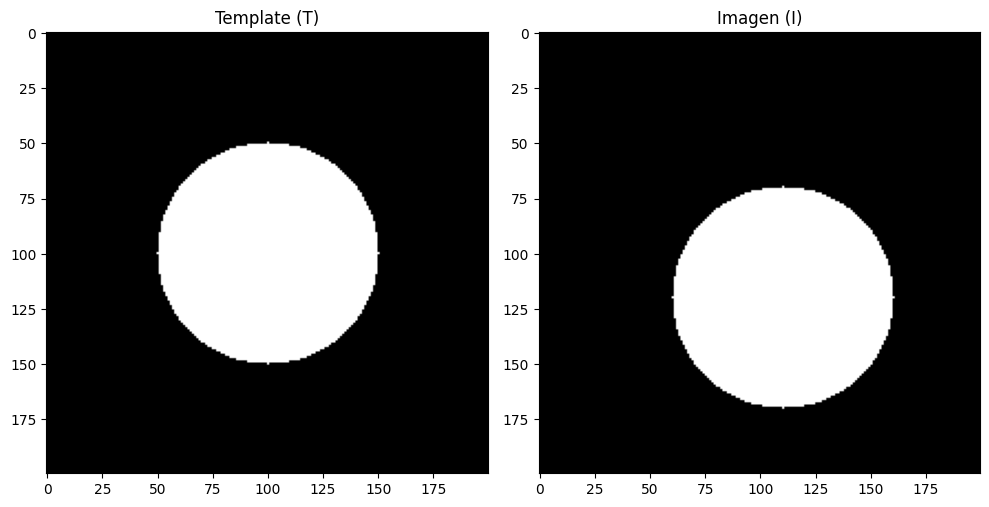

In [32]:
# Crear imágenes de prueba (círculo desplazado)
T_circulo = np.zeros((200, 200), dtype=np.uint8)
cv2.circle(T_circulo, (100, 100), 50, 255, -1)  

I_circulo = np.zeros((200, 200), dtype=np.uint8)
cv2.circle(I_circulo, (110, 120), 50, 255, -1)  # con desplazamiento (10, 20)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(T_circulo, cmap='gray')
plt.title('Template (T)')

plt.subplot(1, 2, 2)
plt.imshow(I_circulo, cmap='gray')
plt.title('Imagen (I)')

plt.tight_layout()
plt.show()

### Un par de imágenes estéreo que nos pasó el dr Jean Bernard.

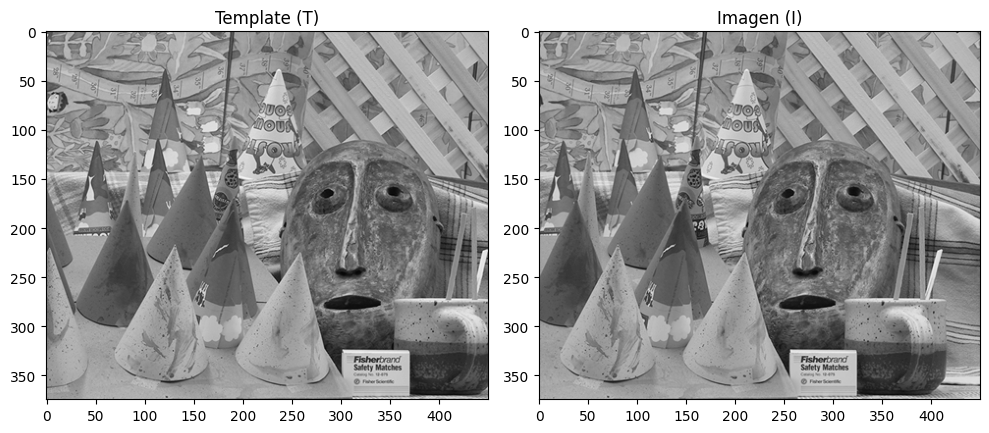

In [31]:
T_im2 = cv2.imread('im2.png', cv2.IMREAD_GRAYSCALE)
im6 = cv2.imread('im6.png', cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(T_im2, cmap='gray')
plt.title('Template (T)')

plt.subplot(1, 2, 2)
plt.imshow(im6, cmap='gray')
plt.title('Imagen (I)')
plt.tight_layout()
plt.show()

## Cálculo del Hessiano y del vector del sistema en Lucas-Kanade

El algoritmo de Lucas-Kanade requiere resolver el siguiente sistema lineal para actualizar los parámetros $\vec{p}$:

$$
H \, \Delta \vec{p} = b
$$

donde:

- El **Hessiano** $H$ se define como:

$$
H = \sum_{\vec{x}} \left[ \nabla I(\vec{x}') \cdot \frac{\partial W}{\partial \vec{p}} \right]^\top
      \left[ \nabla I(\vec{x}') \cdot \frac{\partial W}{\partial \vec{p}} \right]
$$

- El **vector del sistema** $b$ es:

$$
b = \sum_{\vec{x}} \left[ \nabla I(\vec{x}') \cdot \frac{\partial W}{\partial \vec{p}} \right]^\top
     \left[ T(\vec{x}) - I(W(\vec{x}; \vec{p})) \right]
$$

donde:

- $\nabla I(\vec{x}')$ es el gradiente de la imagen transformada `I`,

- $\frac{\partial W}{\partial \vec{p}}$ es el Jacobiano de la transformación,

- $T(\vec{x})$ es la intensidad en la plantilla,

- $I(W(\vec{x}; \vec{p}))$ es la intensidad interpolada de la imagen transformada.



In [6]:
def lucaskanade(T, Img, p, maxiter=10):
    H_t, W_t = T.shape #tomamos la dimensiones de la plantilla
    T = T.astype(np.float32) 
    Img = Img.astype(np.float32) 
    for iteracion in range(maxiter):
        #1. 
        
        #2. Ahora vamos a warpear la imagen 
        
        Img_warped_full = warp_afin(Img, p)

        #3. Ahora calculamos el error
        error = T - Img_warped_full 
        #print(f"Iteración {iteracion + 1}: error = {np.mean(error)}")
        
        #4. Ahora calculamos el gradiente de la imagen usando sobel
        Ix = cv2.Sobel(Img_warped_full, cv2.CV_32F, 1, 0, ksize=3)
        Iy = cv2.Sobel(Img_warped_full, cv2.CV_32F, 0, 1, ksize=3)
       
        #Iniciamos H y b para el sistema a resolver y se irán acumulando por iteracion
        H = np.zeros((2, 2), dtype=np.float32)
        b = np.zeros(2)
        
        #Ahora sí vamos por nuestro sistema
        for y in range(H_t):
            for x in range(W_t):
                gradiente_I = np.array([Ix[y, x], Iy[y, x]])
                J = Jacobian(x, y) 
                A = gradiente_I @ J 
                H += np.outer(A, A) 
                b += A * error[y, x]
        #5. Resolvemos el sistema H * delta_p = b
        delta_p = np.linalg.inv(H) @ b

        
        
        #6. Actualizamos los parámetros
        p = p + delta_p
        #print(f"Iteración {iteracion + 1}: p = {p}, delta_p = {delta_p}")
        #7. Verificamos la convergencia 
        if np.linalg.norm(delta_p) < 1e-3:
            break
    return p
                


## b.  Usando el algoritmo de Baker-Matthews (Alineamiento por Composición Inversa).

Pseudo-código:
1. Transformar la imagen. $I(W(\vec{x}; \vec{p}))$
2. Calcular el error. $E(\vec{x}) = \left[T(\vec{x}) - I(W(\vec{x}; \vec{p}))\right]$
3. Calcular el gradiente. $\nabla T\left(W(\vec{x}; \vec{0})\right)$
4. Evaluar el Jacobiano. $\frac{\partial W(\vec{x}; \vec{0})}{\partial \vec{p}}$
5. Calcular el Hessiano. $H = \sum_{\vec{x}} \left[\nabla T \frac{\partial W}{\partial \vec{p}}\right]^T \left[\nabla T \frac{\partial W}{\partial \vec{p}}\right]$
6. Calcular la solución aproximada. $\Delta \vec{p} = H^{-1} \sum_{\vec{x}} \left[\nabla T \frac{\partial W}{\partial \vec{p}}\right]^T E(\vec{x})$
7. Actualizar los parámetros. $W(\vec{x}; \vec{p}) \leftarrow W(\vec{x}; \vec{p}) \circ W(\vec{x}; \Delta \vec{p})^{-1}$





Comentario sobre la actualización de los parámetros, en nuestro caso de traslación (sin rotación ni escalamientos):

$W(\vec{x}; \vec{p}) \leftarrow W(\vec{x}; \vec{p}) \circ W(\vec{x}; \Delta \vec{p})^{-1}$

Definimos a $W(\vec{x}; \vec{p}) =  x + p$ para el caso de la traslaciíon, por lo que la composición se vía como:

$W(\vec{x} - \Delta p; \vec{p}) = (x - \Delta p) + p = x + (p - \Delta p)$

Por lo que nuestro $p_{actualizado} = p - \Delta p$, pero en el algoritmo de Bakers-Matthew ya tenemos nuestro $\Delta p$ con signo negativo, por lo que volvemos a reescribir como $p_{actualizado} = p + \Delta p$, tal y como en Lucas-Kanade.


In [7]:
def baker_matthews(T, Img, p, maxiter):
    H_t, W_t = T.shape
    T = T.astype(np.float32)
    Img = Img.astype(np.float32)
    
    Ix_T = cv2.Sobel(T, cv2.CV_32F, 1, 0, ksize=3)
    Iy_T = cv2.Sobel(T, cv2.CV_32F, 0, 1, ksize=3)
    
    A_vectors = []
    H = np.zeros((2, 2), dtype=np.float32)
    #Aquí van varios pasos para cosas que se quedan precalculadas
    #a lo largo de todo el proceso
    for y in range(H_t):
        for x in range(W_t):
            #Paso 3. Calcular el gradiente
            gradiente_T = np.array([Ix_T[y, x], Iy_T[y, x]])
            #Paso 4. Calcular el Jacobiano
            J = Jacobian(x, y)
            A = gradiente_T @ J
            #Paso 5. Calcular el Hessiano.
            H += np.outer(A, A)
            A_vectors.append((A, y, x))
    #Aquí inicia el paso 6. Calcular la solución aproximada.
    H_inv = np.linalg.inv(H)
    
    for iteracion in range(maxiter):
        #Paso 1. Transformamos la imagen
        Img_warped_full = warp_afin(Img, p)
        #Paso 2. Calcular el error
        error = T - Img_warped_full

        suma_gradientes = np.zeros(2)
        #Paso 6. Calcular la solución aproximada (usamos A, y el Hessiano)
        for A, y, x in A_vectors:
            suma_gradientes += A * error[y, x]
        #Paso 7. Actualizar los parámetros (solo es el caso de traslación)
        delta_p = H_inv @ suma_gradientes
        p = p + delta_p
        #print(f"Iteración {iteracion + 1}: p = {p}, delta_p = {delta_p}")
        
        if np.linalg.norm(delta_p) < 1e-3:
            break
            
    return p


Vamos a probar el algoritmo con las imágenes que inicializamos al iniio del cuadernillo.

In [8]:
p_final_rectangulo = lucaskanade(T_rectangulo, I_rectangulo, p, maxiter=500)
print(f"El valor de p final es: {p_final_rectangulo}")

El valor de p final es: [10.07202358 20.07651855]


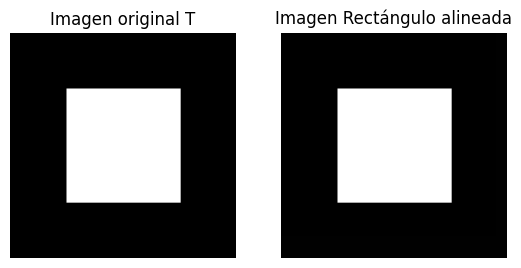

In [30]:
Img_warped_rectangulo = warp_afin(I_rectangulo, p_final_rectangulo)

plt.subplot(1, 2, 1)
plt.title("Imagen original T")
plt.imshow(T_rectangulo, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Imagen Rectángulo alineada")
plt.imshow(Img_warped_rectangulo, cmap='gray')
plt.axis('off')
plt.show()

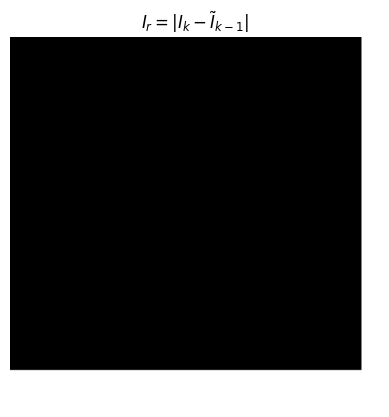

In [10]:
I_r_mascaras = np.abs(T_rectangulo.astype(float) - Img_warped_rectangulo.astype(float))

plt.imshow(I_r_mascaras, cmap='gray')
plt.title(r"$I_r = |I_k - \tilde{I}_{k-1}|$")
plt.axis('off')
plt.show()

In [11]:
p_final_rectangulo_bm = baker_matthews(T_rectangulo, I_rectangulo, p, maxiter=200)
print(f"El valor de p final es: {p_final_rectangulo_bm}")

El valor de p final es: [10.07362078 20.07679231]


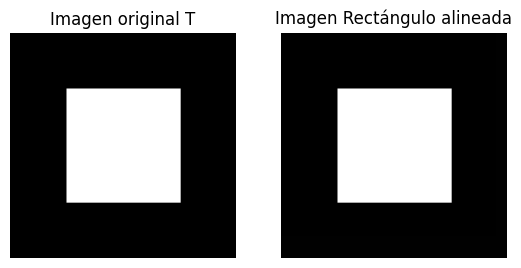

In [29]:
Img_warped_rectangulo_bm = warp_afin(I_rectangulo, p_final_rectangulo_bm)

plt.subplot(1, 2, 1)
plt.title("Imagen original T")
plt.imshow(T_rectangulo, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Imagen Rectángulo alineada")
plt.imshow(Img_warped_rectangulo_bm, cmap='gray')
plt.axis('off')
plt.show()

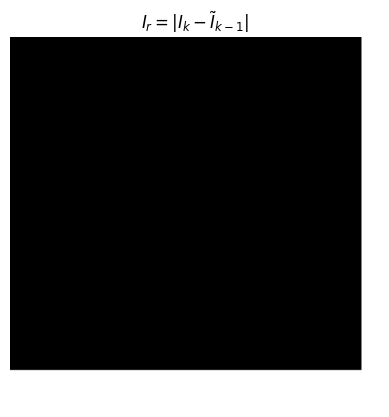

In [13]:
I_r_rectangulo_bm = np.abs(T_rectangulo.astype(float) - Img_warped_rectangulo_bm.astype(float))

plt.imshow(I_r_rectangulo_bm, cmap='gray')
plt.title(r"$I_r = |I_k - \tilde{I}_{k-1}|$")
plt.axis('off')
plt.show()

Evaluamos Lucas-Kanade y Baker-Matthews con la figura del círculo.

In [14]:
p_final_circulo = lucaskanade(T_circulo, I_circulo, p, maxiter=500)
print(f"El valor de p final es: {p_final_circulo}")

El valor de p final es: [10.05901708 20.09416982]


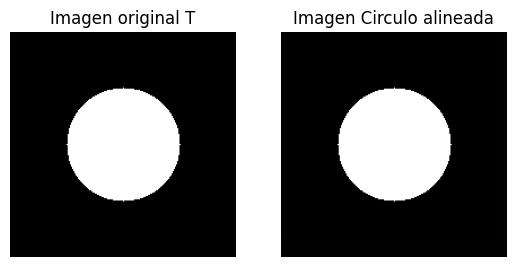

In [28]:
Img_warped_circulo = warp_afin(I_circulo, p_final_circulo)
plt.subplot(1, 2, 1)
plt.title("Imagen original T")
plt.imshow(T_circulo, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Imagen Circulo alineada")
plt.imshow(Img_warped_circulo, cmap='gray')
plt.axis('off')
plt.show()


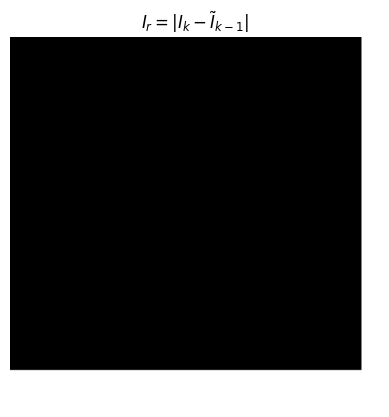

In [16]:
I_r_circulo = np.abs(T_circulo.astype(float) - Img_warped_circulo.astype(float))

plt.imshow(I_r_circulo, cmap='gray')
plt.title(r"$I_r = |I_k - \tilde{I}_{k-1}|$")
plt.axis('off')
plt.show()

In [17]:
p_final_circulo_bm = baker_matthews(T_circulo, I_circulo, p, maxiter=200)
print(f"El valor de p final es: {p_final_circulo_bm}")

El valor de p final es: [10.0594156  20.09448306]


Aplicamos el <pre> p_final </pre> a la imagen del círculo

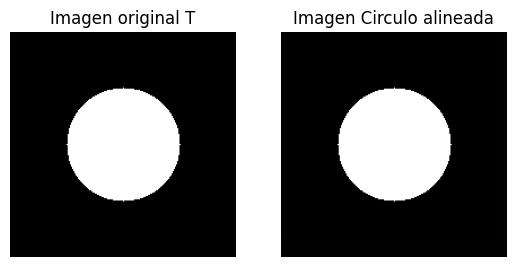

In [27]:
Img_warped_circulo_bm = warp_afin(I_circulo, p_final_circulo_bm)

plt.subplot(1, 2, 1)
plt.title("Imagen original T")
plt.imshow(T_circulo, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Imagen Circulo alineada")
plt.imshow(Img_warped_circulo_bm, cmap='gray')
plt.axis('off')
plt.show()

Ahora restamos ambas imágenes y visualizamos.

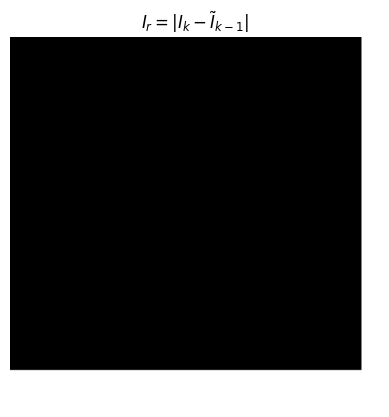

In [19]:
I_r_circulo_bm = np.abs(T_circulo.astype(float) - Img_warped_circulo_bm.astype(float))

plt.imshow(I_r_circulo_bm, cmap='gray')
plt.title(r"$I_r = |I_k - \tilde{I}_{k-1}|$")
plt.axis('off')
plt.show()

In [20]:
p_final_im6 = lucaskanade(T_im2, im6, p, maxiter=2000)
print(f"El valor de p final es: {p_final_im6}")

El valor de p final es: [-1.00507636  1.98947865]


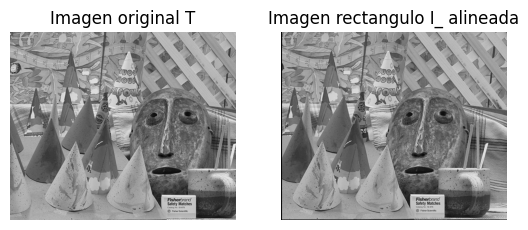

In [ ]:
Img_warped_im6 = warp_afin(im6, p_final_im6)

plt.subplot(1, 2, 1)
plt.title("Imagen original T")
plt.imshow(T_im2, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Imagen Mascaras alineada")
plt.imshow(Img_warped_im6, cmap='gray')
plt.axis('off')
plt.show()

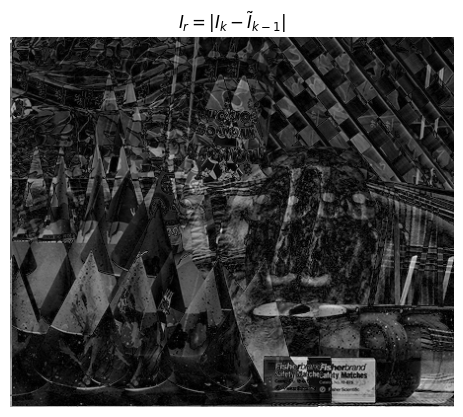

In [22]:
I_r_im6= np.abs(T_im2.astype(float) - Img_warped_im6.astype(float))

plt.imshow(I_r_im6, cmap='gray')
plt.title(r"$I_r = |I_k - \tilde{I}_{k-1}|$")
plt.axis('off')
plt.show()

In [23]:

p_final_im6_bm = baker_matthews(T_im2, im6, p, maxiter=2000)
print(f"El valor de p final es: {p_final_im6_bm}")

El valor de p final es: [-2.21520541e+01  3.99413600e-03]


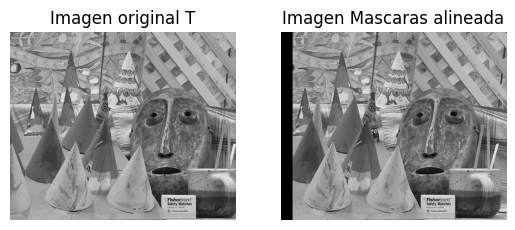

In [26]:
Img_warped_im6_bm = warp_afin(im6, p_final_im6_bm)

plt.subplot(1, 2, 1)
plt.title("Imagen original T")
plt.imshow(T_im2, cmap='gray')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.title("Imagen Mascaras alineada")
plt.imshow(Img_warped_im6_bm, cmap='gray')
plt.axis('off')
plt.show()

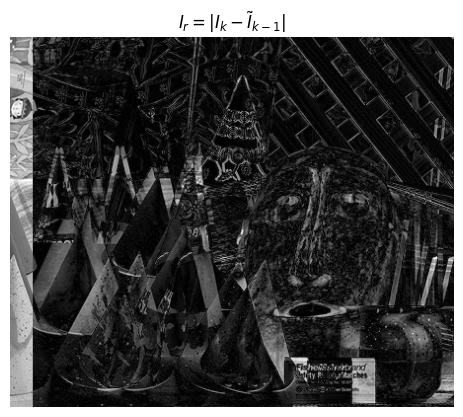

In [25]:
I_r_im6_bm = np.abs(T_im2.astype(float) - Img_warped_im6_bm.astype(float))

plt.imshow(I_r_im6_bm, cmap='gray')
plt.title(r"$I_r = |I_k - \tilde{I}_{k-1}|$")
plt.axis('off')
plt.show()